# Import

In [1]:
!pip install optuna

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Flatten
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

In [6]:
data_location = "/content/gdrive/MyDrive/First Year 2022-23/Spring 1 9-5 1 2023/NSC 325 Invester Program Energy/arXiv/data"

# Data

In [7]:
# import the dataset with encoded categorical variables
df = pd.read_csv(f"{data_location}/UT_Comp_Seq_encode.csv", index_col=0)

In [8]:
x = df.drop('12 month Cum Prod', axis = 1) # Features
y = df['12 month Cum Prod']

scaler = StandardScaler()

x = scaler.fit_transform(x)
y = scaler.fit_transform(np.array(y).reshape(-1, 1))
# x_train and y_train now contain 60% of the data.
# x_val and y_val contain 20% of the data for validation.
# x_test and y_test contain the remaining 20% of the data for testing
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=121)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1)

## test

In [8]:
# create a deep copy of df
df1 = df.copy()
# Create a new column called 'avg_12_month_prod'
df1['avg_12_month_prod'] = 0

In [9]:
# name: (year, month)
# group: a dataframe with that specific year and month
for name, group in df1.groupby(['Year Fracd', 'Month Fracd']):
  # average 12-month cumulative production for each group
  avg_prod = np.mean(group['12 month Cum Prod'])
  # all rows in the group have the same avg_prod
  df1.loc[group.index, 'avg_12_month_prod'] = avg_prod

In [10]:
# drop the original predicted variable
df1 = df1.drop('12 month Cum Prod', axis = 1)

# Optuna

In [ ]:
# Assuming x_train and x_val are Pandas DataFrames
x_train_reshaped = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val_reshaped = x_val.values.reshape((x_val.shape[0], x_val.shape[1], 1))

# Define the objective function for Optuna
def objective(trial):
    rnn = Sequential()
    rnn.add(LSTM(units=trial.suggest_int('units_input', 30, 60), return_sequences=True, input_shape=(x_train_reshaped.shape[1], 1)))

    for i in [True, True, False]:
      rnn.add(LSTM(units = trial.suggest_int('units_lstm', 30, 90), return_sequences = i))
      rnn.add(Dropout(trial.suggest_float('dropout', 0.0, 0.5)))

    # Add Flatten layer when return_sequences is False


    rnn.add(Dense(units=1))

    optim = Adam(
        learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-2),
        beta_1=trial.suggest_float('beta_1', 0.7, 0.99),
        beta_2=trial.suggest_float('beta_2', 0.99, 0.999),
        epsilon=trial.suggest_float('epsilon', 1e-08, 1e-06),
        weight_decay=trial.suggest_float('weight_decay', 1e-7, 1e-5),
        use_ema=trial.suggest_categorical('use_ema', [True, False]),
        ema_momentum=trial.suggest_float('ema_momentum', 0.95, 0.99),
        jit_compile=trial.suggest_categorical('jit_compile', [True, False])
    )

    rnn.compile(optimizer=optim, loss='mean_squared_error', metrics=['mse'])

    # Train the model
    rnn.fit(x_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(x_val_reshaped, y_val), verbose=0)

    # Evaluate on the validation set
    mse = rnn.evaluate(x_val_reshaped, y_val, verbose=0)[1]

    return mse

# Create Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2023-11-24 05:14:07,690] A new study created in memory with name: no-name-794fa198-8ab0-44fa-8fc8-b7ade8a6caa8
[I 2023-11-24 05:24:46,047] Trial 0 finished with value: 386.41217041015625 and parameters: {'units_input': 51, 'units_lstm': 87, 'dropout': 0.19809078052270868, 'learning_rate': 0.0064315430019908785, 'beta_1': 0.7724189157333093, 'beta_2': 0.995838870150862, 'epsilon': 3.285678542325292e-07, 'weight_decay': 7.372927944253755e-06, 'use_ema': True, 'ema_momentum': 0.9805254675630778, 'jit_compile': True}. Best is trial 0 with value: 386.41217041015625.
[I 2023-11-24 05:33:23,026] Trial 1 finished with value: 386.6595764160156 and parameters: {'units_input': 54, 'units_lstm': 59, 'dropout': 0.19847807395962447, 'learning_rate': 0.005557590503371161, 'beta_1': 0.8503461925566674, 'beta_2': 0.991368715769028, 'epsilon': 3.161805626087015e-07, 'weight_decay': 7.397992070382463e-07, 'use_ema': True, 'ema_momentum': 0.964007510417234, 'jit_compile': True}. Best is trial 0 with va

# Train

In [16]:
# initialize the recurrent neural network
rnn = Sequential()

In [17]:
# adding the first LSTM layer
# units = 45 : number of LSTM neurons
# input_shape : 1 predictor
rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (x_train.shape[1], 1)))

In [18]:
# Then, a loop adds additional LSTM layers. The loop iterates three times, adding two layers that return sequences (True) and one layer that doesn't (False). Dropout layers with a rate of 0.1 are added after each LSTM layer.
# adding some dropout regularization to avoid overfitting
# randomly excluding - or “dropping out” - certain layer outputs during the training stage
# dropout rate of 10%
for i in [True, True, False]:
    rnn.add(LSTM(units = 60, return_sequences = i))
    rnn.add(Dropout(0.1))

In [19]:
# adding the output layer
# A Dense layer with 1 unit is added. This is typical for regression problems where you're predicting a continuous variable.
rnn.add(Dense(units = 1))

In [25]:
# The model uses the Adam optimizer with specific parameter values.
# compiling the rnn
# specify the optimizer and loss parameters
# adam optimizer and mean squared error
optim = Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=1e-6,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=True,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam'
    )

rnn.compile(optimizer = optim, loss = 'mean_squared_error', metrics=['accuracy'])

In [26]:
# training the rnn on the training data
history = rnn.fit(x_train, y_train, epochs = 9, batch_size = 32, verbose=1, validation_data=(x_val, y_val))

Epoch 1/9
101/203 [=============>................] - ETA: 19s - loss: 1.0463 - accuracy: 0.0000e+00

KeyboardInterrupt: ignored

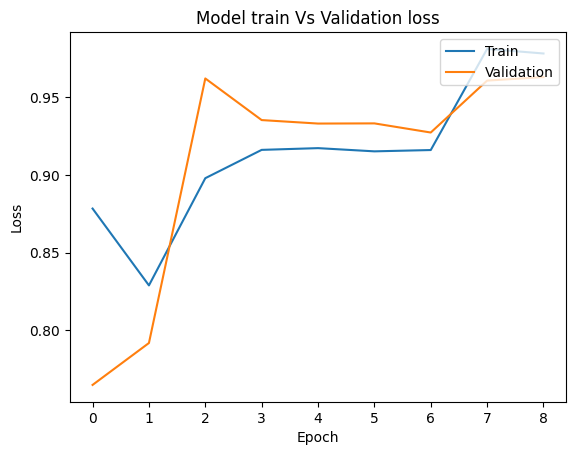

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model train Vs Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [53]:
y_pred = rnn.predict(x_test)

68/68 [==============================] - 5s 51ms/step


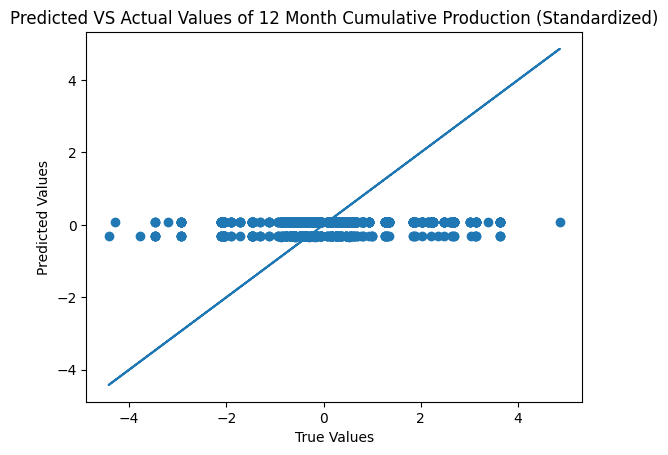

In [54]:
plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted VS Actual Values of 12 Month Cumulative Production (Standardized)')
plt.show()

In [55]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error: {:.2f}".format(mse))

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: {:.2f}".format(rmse))

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error: {:.2f}".format(mae))

# R2 Score (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)
print("R2 Score: {:.2f}".format(r2))

Mean Squared Error: 1.00
Root Mean Squared Error: 1.00
Mean Absolute Error: 0.70
R2 Score: 0.01
